# Proyecto Final: Problema Gravitacional de los N-Cuerpos

### Desarrollado por:

* Joar Esteban Buitrago Carrillo
* Juan Sebastian Montoya Combita  

  

**Observatorio Astronómico Nacional**

2021

Las ecuaciones de movimiento de N-Partículas moviendose bajo su interacción gravitacional mutua se puede escribir en la forma.
$$m_{i}\ddot{x}_{i} = -Gm_{i} \sum_{j=1, i \neq j}^{N} \frac{m_{j}}{|x_{ij}|^{2}}$$
Donde $x_{ij}=x_{i}-x_{j}$ es el vector que apunta desde la partícula $j$ a la partícula $i$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import plotly.graph_objects as go
from copy import deepcopy
from urllib.request import urlretrieve #to download from url 
import os

##   1.   Generalización:
Implemente un código que resuelva el problema diferencial de las ecuaciones de movimiento utilizando un método Runge-Kutta de orden 4. El algoritmo debe ser lo suficientemente general para poder incluír un número arbitrario de partículas y las condiciones deben ser leídas de un archivo.






1.   Primero, se crea la clase principal para cada cuerpo



In [ ]:
class Astrobject:
  """This is an abstraction of how to implement an Astronomical Object.
  
  :param pos: The initial position of the object, defaults to np.zeros(3)*u.au.
  :type pos: A numpy array of size 3 with distance Quantity, optional.
  
  :param vel: The initial velocity of the object, defaults to np.zeros(3)*u.au/u.year.
  :type vel: A numpy array of size 3 with velocity Quantity, optional.
  
  :param mass: The initial mass of the object, defaults to 1.*u.M_sun.
  :type mass: A mass Quantity scalar, optional.
  
  """
  @u.quantity_input
  def __init__(
      self,
      pos: u.au = np.zeros(3) * u.au, 
      vel: u.au/u.year = np.zeros(3) * u.au/ u.year,
      mass: u.M_sun = 1. * u.M_sun
  ):
    """Constructor method."""
    self.pos = pos
    self.vel = vel
    assert(mass > 0)
    self.mass = mass
    self._clear()
    
  def __str__(self):
    """Renders the object as a string."""
    return "Astronomical object with a mass of %s\n" % self.mass
  
  def __repr__(self):
    """Show a pretty representation of the object."""
    return self.__str__()

  def _clear(self):
    """Clears and reset the force accumulator."""
    self._acc = np.zeros(3) * u.au / (u.year ** 2)

  @u.quantity_input
  def acc(
      self,
      mass: u.M_sun, 
      distance: u.au
  ):
    """Return acceleration due to other object.
    
    :param mass: The mass of the other object.
    :type mass: A mass Quantity scalar.
    
    :param distance: The distance vector between the objects.
    :type distance:  A numpy array of size 3 with distance Quantity.
    
    :return: The acceleration vector due to other object.
    :rtype: A numpy array of size 3 with force/mass Quantity.
    
    """
    up = mass * distance * const.G
    down = np.linalg.norm(distance) ** 3
    return - (up / down)

  @u.quantity_input
  def add_interaction(
      self,
      other
  ):
    """Add interaction using Strömer-Verlet without velocities method.
    
    Add the interaction to the diff to before use in step function.
    
    :param other: The other object to interact with.
    :type other: class:`Astrobject`
    
    """
    distance = (self.pos - other.pos).to(u.au)
    
    self._acc += self.acc(other.mass, distance)

  def step(
      self,
      dt,
      prev = None
  ):
    """Step the object in time and reset the force accumulator."""
    if prev == None:
      self.pos = self.pos + self.vel * dt + 1/2 * self._acc * dt ** 2
      
    else:
      self.pos = 2 * self.pos - prev.pos + self._acc * dt ** 2
    
    self._clear()

2. Creación de la clase que guarda un arreglo de clases para cada cuerpo

In [ ]:
class Astrosystem:
  """This is an abstraction of an Astronomical System.
    
  :param pos_unit: The unit of the position, defaults to u.au.
  :type pos_unit: A distance unit, optional.
  
  :param vel_unit: The unit of the velocity, defaults to u.au/u.year.
  :type vel_unit: A velocity unit, optional.
  
  :param mass_unit: The unit of the mass, defaults to u.M_sun.
  :type mass_unit: A mass unit, optional.
  
  """
  @u.quantity_input
  def __init__(
      self,
      pos_unit: u.au = 1.*u.au,
      vel_unit: u.au/u.year = 1.*u.au/u.year,
      mass_unit: u.M_sun = 1.*u.M_sun
  ):
    """Constructor method."""
    self.pos_unit = pos_unit
    self.vel_unit = vel_unit
    self.mass_unit = mass_unit
    
    self.data = np.array(())
    
  def __str__(self):
    """Renders the object as a string."""
    return "Astronomical System with %d objects\n" % self.size
  
  def __repr__(self):
    """Show a pretty representation of the object."""
    return self.__str__()
    
  def loadtxt(self, *args, **kwargs):
    """Loads and parse a txt with the format pos*3, vel*3, mass.
    
    :param args: Arguments passed directly to numpy loadtxt.
    
    :param kwargs: Keyword arguments passed directly to numpy loadtxt.
    
    """
    self.data = np.loadtxt(*args, **kwargs)
    
    self.objects = np.array([
      Astrobject(
        (row[0:3] * self.pos_unit).to(u.au),
        (row[3:6] * self.vel_unit).to(u.au/u.year),
        (row[6] * self.mass_unit).to(u.M_sun)
      )
        for row in self.data
    ])
    
  @property
  def size(self):
    """Return the actual system size.
    
    :rtype: int
    
    """
    return self.data.shape[0]
    
  @staticmethod
  def distance(
      object_a: Astrobject,
      object_b: Astrobject
  ):
    """Return the distance betweem the two objects."""
    return np.linalg.norm(object_a.pos - object_b.pos)
    
  @u.quantity_input
  def advance_time(
      self,
      total_time: u.year,
      delta_time: u.year
  ):
    """Integrates the system from actual instance to total_time.
    
    The time steps are calculated using AstroPy functionality.
    
    :param total_time: The diff of time in which the system will operate.
    :type total_time: A time Quantity scalar.
    
    :param delta_time: The diff of time in which to calc the steps.
    :type total_time: A time Quantity scalar.
    
    """
    # Calculate total time steps
    time = int ((total_time.to(delta_time.unit)) / delta_time)
    
    # Create the array of times for later analysis
    self.time_objects = np.empty((time, self.size), dtype=Astrobject)

    for t in range(time):
      for object_a in self.objects:
        for object_b in self.objects:
          
          # Skip interacting with the same object
          if object_a is object_b:
            continue
        
          object_a.add_interaction(object_b)
            
      # After adding all the interactions step the objects and persist them in the time array
      time_objects = np.array([], dtype=Astrobject)
      
      for index in range(self.size):
        body = self.objects[index]
        
        # Fisrt store the actual object in time
        time_objects = np.append(time_objects, deepcopy(body))
        
        if t == 0:
          prev_body = None
        else:
          prev_body = self.time_objects[t-1, index]
        
        # Then step one time step ahead
        body.step(delta_time, prev_body)
        
      self.time_objects[t] = time_objects
    
    # Calculate the final velocities
    self.calc_vel(delta_time)
      
  def calc_vel(
      self,
      dt
  ):
    for time in range(1, self.time_objects.shape[0]):
      time_objects = self.time_objects[time]
      
      for index in range(time_objects.shape[0]):
        body = time_objects[index]
        
        if time == (self.time_objects.shape[0] - 1):
          body.vel = self.time_objects[time, index].pos - self.time_objects[time - 1, index].pos
          body.vel /= dt

        else:
          body.vel = self.time_objects[time + 1, index].pos - self.time_objects[time - 1, index].pos
          body.vel /= 2 * dt
      
  @property
  def energy(self):
    energies = np.array([]) * u.J
    
    def kinetic(body):
      vel = np.linalg.norm(body.vel)
      return 0.5 * body.mass * vel ** 2
    
    def potential(object_a, object_b):
      dis = np.linalg.norm(object_a.pos - object_b.pos)
      return const.G * object_a.mass * object_b.mass / dis
    
    for time in self.time_objects:
      energy = 0

      for object_a in time:
        energy += kinetic(object_a)
        
        for object_b in time:
          
          # Skip same object
          if object_a is object_b:
            continue
          energy += potential(object_a, object_b)
        
      energies = np.append(energies, energy)
        
    return energies
        
      
  @u.quantity_input
  def show(
      self,
      dis_unit: u.au = 1.*u.au,
      *args,
      **kwargs
  ):
    """Creates a graph using plotly of the system."""
    if not hasattr(self, "time_objects"):
      return "Not integrated yet."
    
    fig = go.Figure()
    for i in range(self.time_objects.shape[1]):
      x, y, z = np.array([
        body.pos.to(dis_unit) 
          for body in self.time_objects[:,i]
      ]).transpose()
      fig.add_trace(
        go.Scatter3d(
          x = x,
          y = y,
          z = z,
          mode='lines'
        )
      )
    fig.show()
    
  def show_energy(self, *args, **kwargs):
    """Create a graph of the energy with matplotlib."""
    plt.figure(figsize=(16,9))
    plt.plot(
      range(self.time_objects.shape[0]),
      self.energy
    )
    plt.xlabel("Time steps")
    plt.ylabel("Energy")
    plt.show()

## 2.   Simulación sistema Sol-Tierra:
Con el fin de probar el código implementado, utilice los datos iniciales para el sistema Sol-Tierra dados en el archivo sun_earth.csv y grafique el comportamiento del sistema a lo largo de algunos años. Compruebe que la orbita no se comporta a la forma de una espiral.

1. Crear y cargar el sistema.

In [ ]:
if not os.path.isfile('sun_earth.csv'):
    print("Downloading sun earth data files")
    conceptnet_url = 'https://raw.githubusercontent.com/ObservatorioAstronomicoNacional/Final-Project-Computational-Astrophysics/main/sun_earth.csv'
    urlretrieve(conceptnet_url, 'sun_earth.csv')

In [ ]:
sun_earth = Astrosystem(1.*u.m, 1.*u.m/u.s, 1.*u.kg)
sun_earth.loadtxt("sun_earth.csv", delimiter=",")

sun_earth

Astronomical System with 2 objects

2. Integrar el systema

In [ ]:
sun_earth.advance_time(5.*u.year, 1.*u.day)

3. Graficar

In [ ]:
sun_earth.show()

## 3.   Aseguramiento de Convergencia:

Con el fin de asegurar la convergencia del algoritmo, implemente una rutina dentro del programa que calcule la energía total del sistema de N-partículas. Evalue el comportamiento de la energía a lo largo de la evolución y grafique para comprobar si existe algún cambio significativo. ¿El comportamiento mejora o empeora al modificar el paso de la integración?

In [ ]:
sun_earth.energy

<Quantity [1.32451250e+34, 1.32451258e+34, 1.32451280e+34, ...,
           1.32451286e+34, 1.32451261e+34, 1.32453211e+34] J>

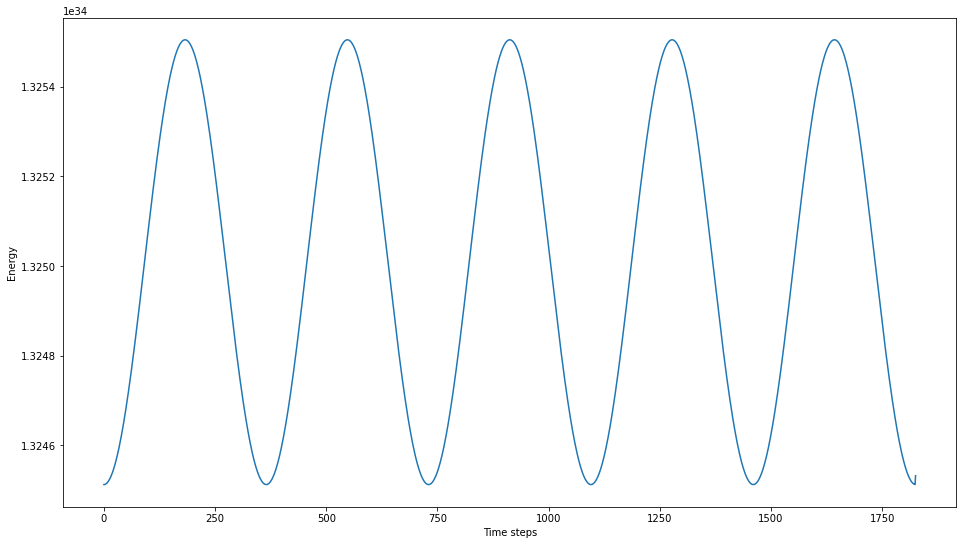

In [ ]:
sun_earth.show_energy()

In [ ]:
print("The energy deviation is: %s" % np.std(sun_earth.energy))

The energy deviation is: 3.5065600592816783e+30 J


In [ ]:
max_energy = np.max(sun_earth.energy)
min_energy = np.min(sun_earth.energy)

deviation = (max_energy - min_energy) / min_energy * 100

print("The relative energy deviation is: %s" % deviation)

The relative energy deviation is: 0.07486730782223659


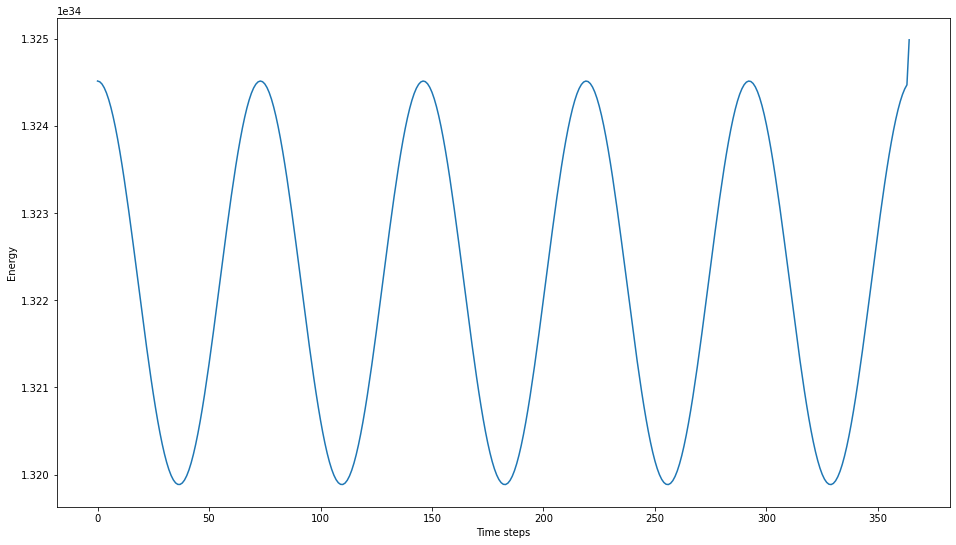

In [ ]:
sun_earth.loadtxt("sun_earth.csv", delimiter=",")
sun_earth.advance_time(5.*u.year, 5.*u.day)
sun_earth.show_energy()

In [ ]:
print("The energy deviation is: %s" % np.std(sun_earth.energy))

The energy deviation is: 1.6372237680555973e+31 J


In [ ]:
max_energy = np.max(sun_earth.energy)
min_energy = np.min(sun_earth.energy)

deviation = (max_energy - min_energy) / min_energy * 100

print("The relative energy deviation is: %s" % deviation)

The relative energy deviation is: 0.38629521394706184


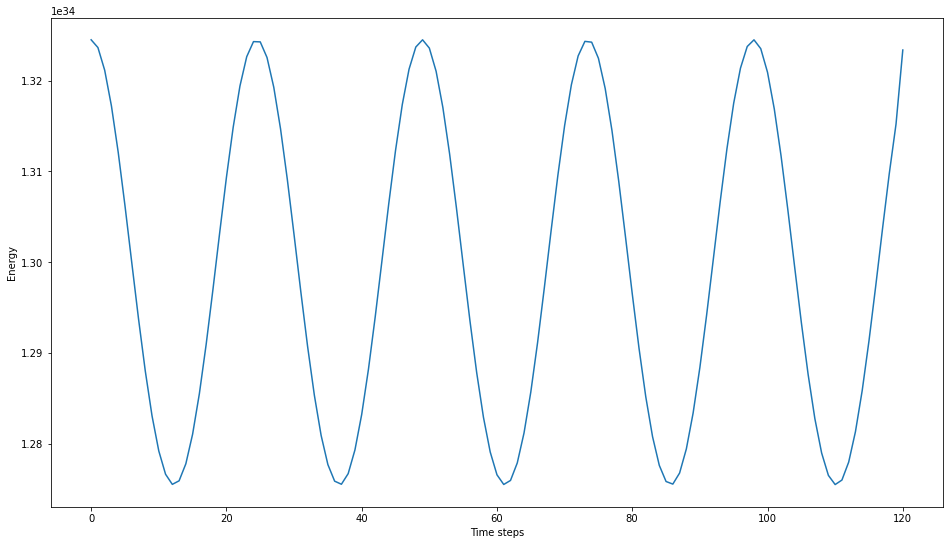

In [ ]:
sun_earth.loadtxt("sun_earth.csv", delimiter=",")
sun_earth.advance_time(5.*u.year, 15.*u.day)
sun_earth.show_energy()

In [ ]:
print("The energy deviation is: %s" % np.std(sun_earth.energy))

The energy deviation is: 1.729307601547538e+32 J


In [ ]:
max_energy = np.max(sun_earth.energy)
min_energy = np.min(sun_earth.energy)

deviation = (max_energy - min_energy) / min_energy * 100

print("The relative energy deviation is: %s" % deviation)

The relative energy deviation is: 3.844663220714277


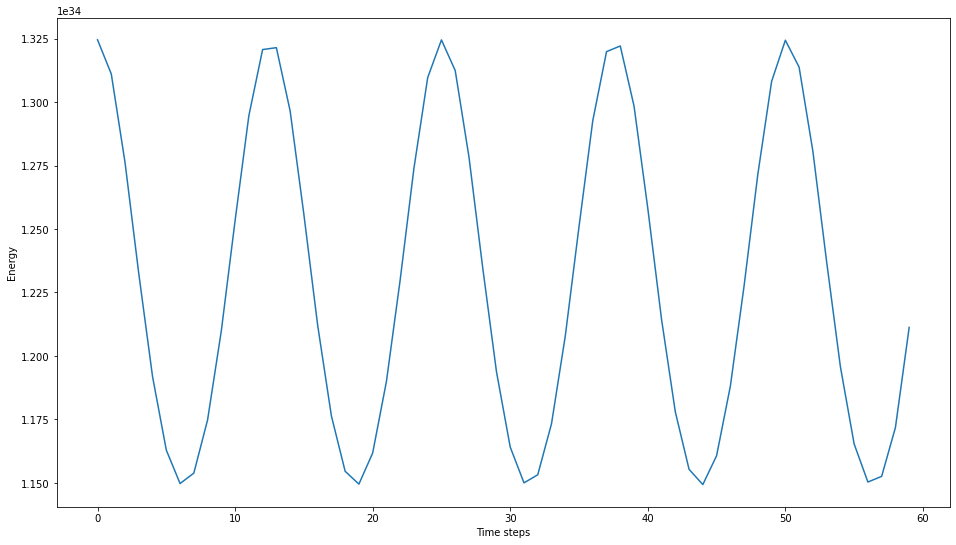

In [ ]:
sun_earth.loadtxt("sun_earth.csv", delimiter=",")
sun_earth.advance_time(5.*u.year, 30.*u.day)
sun_earth.show_energy()

In [ ]:
print("The energy deviation is: %s" % np.std(sun_earth.energy))

The energy deviation is: 6.204771575991794e+32 J


In [ ]:
max_energy = np.max(sun_earth.energy)
min_energy = np.min(sun_earth.energy)

deviation = (max_energy - min_energy) / min_energy * 100

print("The relative energy deviation is: %s" % deviation)

The relative energy deviation is: 15.238471677510276


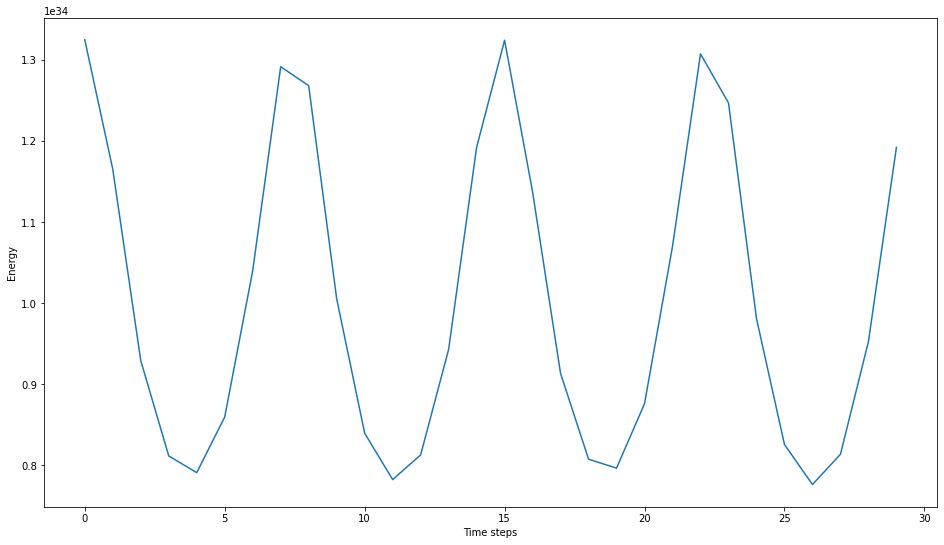

In [ ]:
sun_earth.loadtxt("sun_earth.csv", delimiter=",")
sun_earth.advance_time(5.*u.year, 60.*u.day)
sun_earth.show_energy()

In [ ]:
print("The energy deviation is: %s" % np.std(sun_earth.energy))

The energy deviation is: 1.8995967754764035e+33 J


In [ ]:
max_energy = np.max(sun_earth.energy)
min_energy = np.min(sun_earth.energy)

deviation = (max_energy - min_energy) / min_energy * 100

print("The relative energy deviation is: %s" % deviation)

The relative energy deviation is: 70.62472724021903


In [ ]:
sun_earth.show()

## 4.   Simulación Sistema estrellas alrededor de SgrA*:
Ahora utilice su código para estudiar la evolución del sistema de 13 estrellas moviendose alrededor del agujero negro supermasivo **SgrA***, proporcionado en el archivo sgrAstar.csv. Verifique también el comportamiento de la energía del sistema de 13+1 partículas. Grafique las orbitas de estas estrellas a lo largo de un periodo de 100 años.

In [ ]:
if not os.path.isfile('sgrAstar.csv'):
    print("Downloading sgta* + stars data files")
    conceptnet_url = 'https://raw.githubusercontent.com/ObservatorioAstronomicoNacional/Final-Project-Computational-Astrophysics/main/sgrAstar.csv'
    urlretrieve(conceptnet_url, 'sgrAstar.csv')

In [ ]:
distance = np.tan(1*u.arcsec)*8*u.kpc

sgrAstar = Astrosystem(distance, distance/u.year, 1.*u.M_sun)
sgrAstar.loadtxt('sgrAstar.csv', delimiter=',')

sgrAstar

Astronomical System with 14 objects

In [ ]:
%%time
sgrAstar.advance_time(50.*u.year, 5.*u.day)

CPU times: user 25min 54s, sys: 12.3 s, total: 26min 7s
Wall time: 26min 50s


In [ ]:
sgrAstar.show(distance)

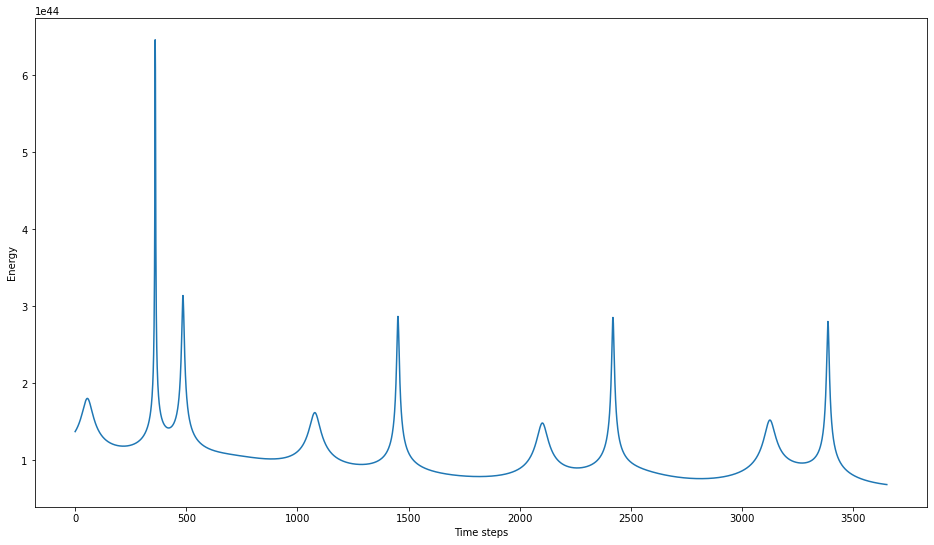

In [ ]:
sgrAstar.show_energy()